# Imblearn: Targeted Modeling

## 1. Imbalanced learning
A common phenomenom in classification is imbalance data, it refers to the situation that a class has too few data and our Machine Learning model cannot put focus to learn it. This phenomenom exists in all types of classification problems, but we will focus only on solving it in *binary classification*. In real-world problems, often times there will be a class being more important than the other but contains only a small fraction of data. For convention, we will denote this class $1$ and the other $0$.

In this section, we will introduce three approaches to fight this challenge: class weighting, using focal loss and resampling, but will focus on the last method using [Imbalanced-learn]. Resampling is divided into over/up-sampling and under/down-sampling as described in the following image.

:::{image} ../image/resampling.png
:height: 160px
:align: center
:::

[Imbalanced-learn]: https://github.com/scikit-learn-contrib/imbalanced-learn

:::{note}

Any method solving imbalanced data causes data leakage.

:::

In [31]:
import warnings
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb

from lightgbm import LGBMClassifier
from sklearn.metrics import ndcg_score as NDCG
from sklearn.metrics import precision_score as Precision
from sklearn.metrics import recall_score as Recall
from sklearn.metrics import fbeta_score as FBeta
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import precision_recall_curve, confusion_matrix

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

### 1.1. Accuracy analysis

#### Precision-Recall
When analyzing the performance of a binary classifier, we usually care about Precision or Recall more than the other. To remind, a $0.65$ Precision indicates $35\%$ users predicted as good are actually bad, and a Recall of $0.2$ indicates $80\%$ good users are predicted as bad. Here is an example of Precision-Recall analysis for a typical case, targeted marketing:
- We don't want to miss any user that actually likes our products. In Machine Learning language, we would want False Negative to be as low as possible, which is equivalent to high Recall.
- On the other hand, we also don't want to sent irrelevant messages to non-promising users (False Positive), because this will spam them and waste our budget. So, Precision should also be high, but not that important when compared to Recall.

According to the above analyses, an F-beta score with $\beta>1$ (which favors Recall) will be a good evaluation metric. In addition, Precision and Recall (and of couse, F-score) vary at different thresholds, so we use the Precision-Recall chart to decide the best theshold.

#### Cumulative gains
The downside of Precision-Recall analyses is that it considers the entire dataset, while our resources (such as time and money) are limited, so caring about how the model distributes its probabilitic predictions is more practical. This is exactly what cumulative gains shows us; a good model commonly gains a high ratio of good users at the three first deciles.

In [46]:
def plotPRChart(yTrue, yProb, beta=1, ax=None):
    from sklearn.metrics import precision_recall_curve
    precision, recall, threshold = precision_recall_curve(yTrue, yProb)
    precision = precision[:-1]
    recall = recall[:-1]
    threshold = np.concatenate(([0], threshold, [1]))
    precision = np.concatenate(([0], precision, [1]))
    recall = np.concatenate(([1], recall, [0]))
    if beta is not None:
        fbeta = 1 / (1/(1+beta**2)/precision + beta**2/(1+beta**2)/recall)
    
    if ax is None:
        ax = plt.gca()
    ax.plot(threshold, precision, label='Precision')
    ax.plot(threshold, recall, label='Recall')
    ax.plot(threshold, fbeta, ls='--', label='F-beta')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.legend()
    ax.axis('scaled')
    return ax

def plotCumulativeGains(yTrue, yProb, ax=None):
    dfProb = pd.DataFrame({'yTrue': yTrue, 'yProb': yProb})
    dfProb = dfProb.sort_values('yProb', ascending=False)
    n = dfProb.shape[0]
    nPositive = dfProb[dfProb.yTrue == 1].shape[0]
    
    deciles = np.linspace(0, 1, 11)
    gains = []
    
    for decile in deciles:
        nVisit = int(n * decile)
        dfGain = dfProb.head(nVisit)
        nGainPositive = dfGain[dfGain.yTrue == 1].shape[0]
        gain = nGainPositive / nPositive
        gains.append(gain)
    
    if ax is None:
        ax = plt.gca()
    ax.plot([0, 1], [0, 1], color='k', linestyle='--')
    ax.plot(deciles, gains, marker='o')
    ax.legend(['Baseline', 'Gains'], loc='best')
    ax.set_xlabel('Deciles')
    ax.set_ylabel('Gains')
    ax.axis('scaled')
    return ax

In [3]:
df = pd.read_csv('../data/credit_scoring.csv')
df = df.fillna(0)
x = df.drop(columns='bad_customer')
y = df['bad_customer']
y.value_counts()

0    139974
1     10026
Name: bad_customer, dtype: int64

In [44]:
model = LGBMClassifier()
model.fit(x, y)
yPred = model.predict(x)
yProb = model.predict_proba(x)[:, 1]

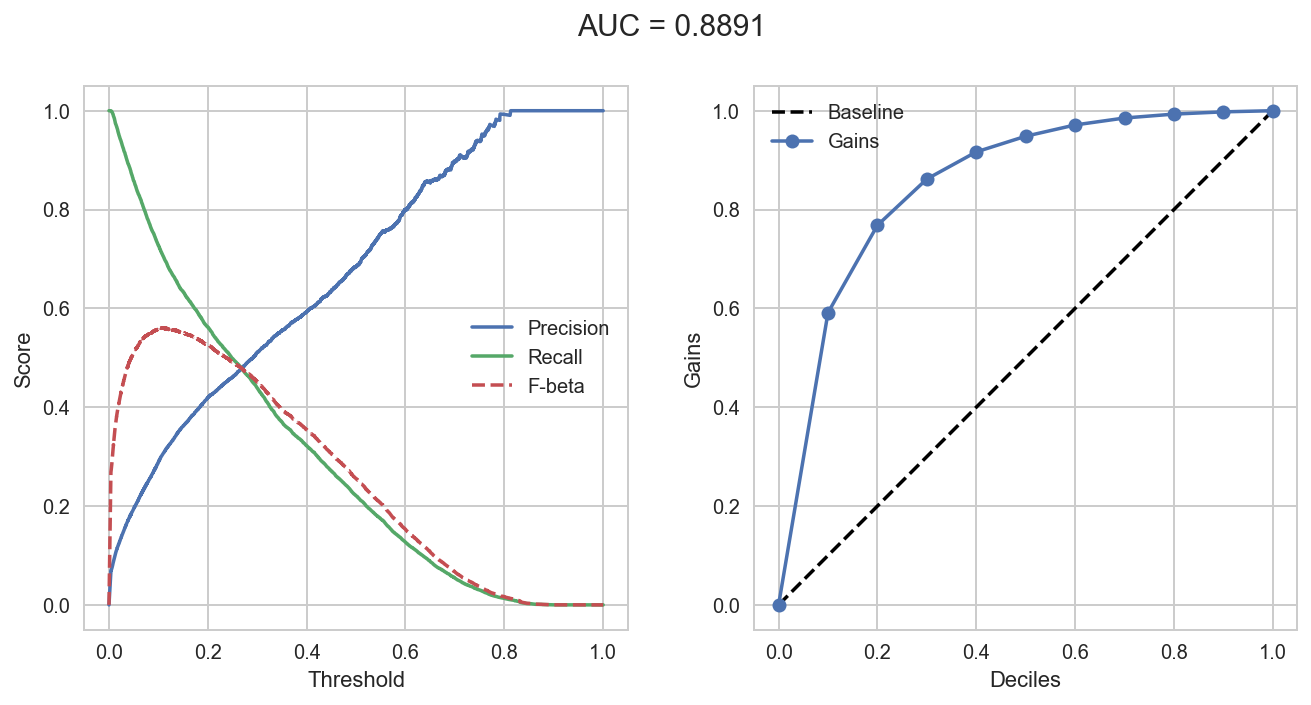

In [47]:
auc = metrics.roc_auc_score(y, yProb)
fig, ax = plt.subplots(ncols=2, figsize=(11,5), sharex=True)
plotPRChart(y, yProb, ax=ax[0], beta=2)
plotCumulativeGains(y, yProb, ax=ax[1])
fig.suptitle(f'AUC = {auc:.4f}', fontsize=15)
plt.show()

#### Class weighting
When train a LightGBM classifier as above, a threshold of $0.5$ witnesses a higher Recall. This behaviour can be controlled by assigning a higher weight to the minority class. Most Scikit-learn's classifiers support this method via the parameter `class_weight`. We can see how this strategy impacts PR-chart: the range of thresholds providing a high F-score is wider than balanced class weights.

In [48]:
model = LGBMClassifier(class_weight={1: 15, 0: 1})
model.fit(x, y)
yPred = model.predict(x)
yProb = model.predict_proba(x)[:, 1]

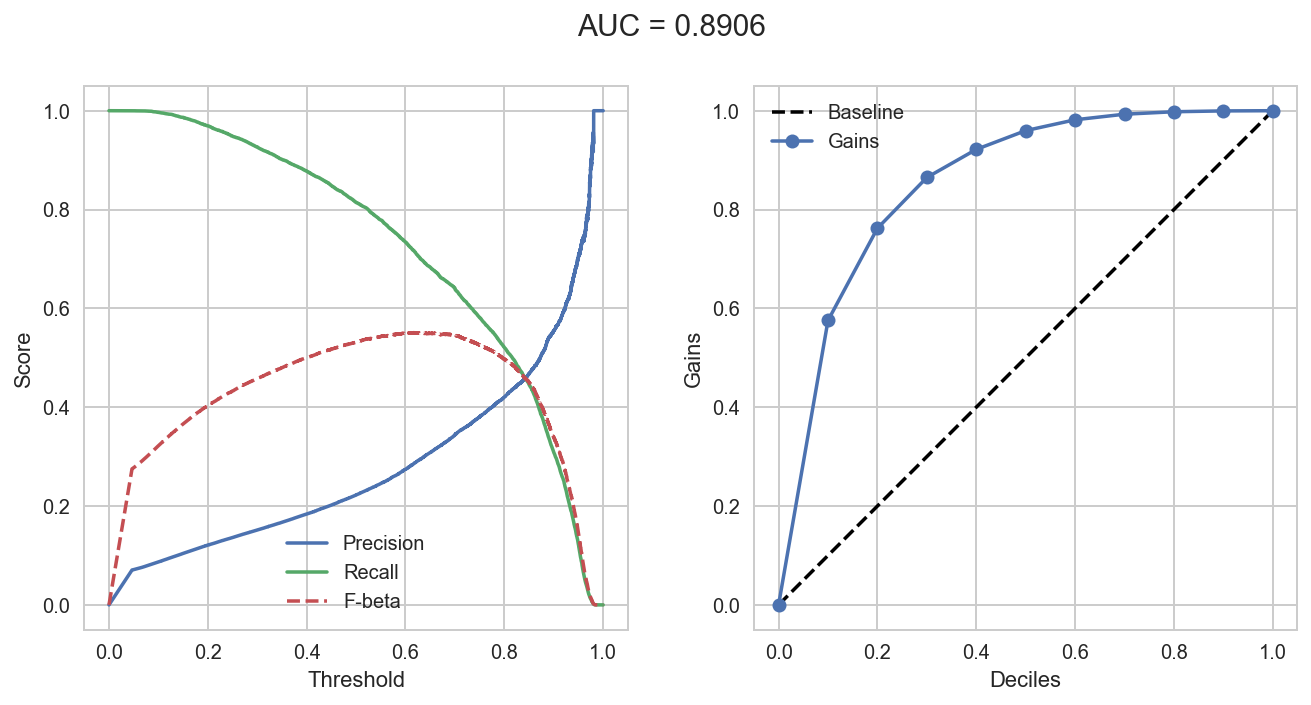

In [49]:
auc = metrics.roc_auc_score(y, yProb)
fig, ax = plt.subplots(ncols=2, figsize=(11,5), sharex=True)
plotPRChart(y, yProb, ax=ax[0], beta=2)
plotCumulativeGains(y, yProb, ax=ax[1])
fig.suptitle(f'AUC = {auc:.4f}', fontsize=15)
plt.show()

### 1.2. Focal loss
Focal Loss, introduced in the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002) (2017) is a variant of Cross Entropy (CE) that prevents the majority class from overwhelmeing the loss function. It has two hyperparameters: $\alpha\in[0,1]$, the *balance* parameter and $\gamma\in[0,\infty]$, the *focusing* parameter. Before going to the Focal Loss formula, we first introduce two artificial variables $p_n$ and $\alpha_n$ defined same way:

$$
p_n=
\begin{cases}
\hat{y}_n   & \text{if }y_n=1 \\
1-\hat{y}_n & \text{if }y_n=0
\end{cases}
\quad\text{and}\quad
\alpha_n=
\begin{cases}
\alpha   & \text{if }y_n=1 \\
1-\alpha & \text{if }y_n=0
\end{cases}
$$

:::{image} ../output/crossentropy_prediction_goodness.png
:height: 250px
:align: center
:::
<br>

Here, $p_n$ represents prediction goodness (higher-is-better) and $\alpha_n$ is simple class weight. The formula of Focal Loss (FL) is then given by:

$$\text{FL}(\hat{\mathbf{y}})=-\sum_{n=1}^N \alpha_n(1-p_n)^\gamma\log{p_n}$$

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
func = lambda x: np.exp(x) / (1 + np.exp(x))

x_plot = np.linspace(-6, 6, 1000)
y_plot = func(x_plot)

xPos = [-2, 1.2, 2]
xNeg = [-1, 0.7]

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12,4), tight_layout=True)

ax[0].axhline(1, color='grey')
ax[0].axhline(0, color='grey')
ax[0].plot(x_plot, y_plot, 'k')
ax[0].grid(False)
ax[0].set_xlabel('Logit (Log-odds)')
ax[0].set_ylabel('Probability')
ax[0].set_title('$\hat{y}_n$, predicted probability')

for i, x_ in enumerate(xPos):
    label = 'Positive' if i==0 else None
    ax[0].plot([x_, x_], [0, func(x_)], c='royalblue', ls='--', label=label)

for i, x_ in enumerate(xNeg):
    label = 'Negative' if i==0 else None
    ax[0].plot([x_, x_], [0, func(x_)], c='indianred', ls='--', label=label)

ax[1].axhline(1, color='grey')
ax[1].axhline(0, color='grey')
ax[1].plot(x_plot, y_plot, 'k')
ax[1].grid(False)
ax[1].set_xlabel('Logit (Log-odds)')
ax[1].set_title('$p_n$, prediction goodness')

for i, x_ in enumerate(xPos):
    label = 'Positive' if i==0 else None
    ax[1].plot([x_, x_], [0, func(x_)], c='royalblue', ls='--', label=label)

for i, x_ in enumerate(xNeg):
    label = 'Negative' if i==0 else None
    ax[1].plot([x_, x_], [1, func(x_)], c='indianred', ls='--', label=label)

ax[0].legend()
fig.savefig('../output/crossentropy_prediction_goodness.png', dpi=500, bbox_inches='tight')
plt.close(fig)

#### Hyperparameters
In an imbalanced classification problem, the majority class dominates the loss function. This makes the the majority class easier to learn, thus $p_n$ in this class tends to be higher than in the minority class. We can see the impact of the term $(1-p_n)^\gamma$ here, it gives smaller weights to those *easy* predictions which are mostly in the negative class. This design, in my opinion, is very smart as it only *discards* the unimportant part but leaves the important part of the negative class to train the next iteration.

:::{image} ../output/imbalanced_probability_distribution.png
:height: 250px
:align: center
:::

In summary:
- The *focusing* parameter, $\gamma$ shows how strong we punish easy predictions. It is recommended by the author to be $2$, otherwise it should be tuned within the range $[0.5,5]$.
- The *balance* parameter, $\alpha$ simply indicates the weight of the positive class. Although $\alpha<0.5$ favors the negative class, the recommended value for it is $0.25$. This can be explained that most of the focusing effect of this function comes from $\gamma$, and since it already favors class $1$, a low $\alpha$ will compensate that a bit. In the case you want to tune this parameter, it should be set within the range $[0.25,0.75]$.

In [4]:
df = pd.read_csv('../data/credit_scoring.csv')
df = df.fillna(0)
x = df.drop(columns='bad_customer')
y = df['bad_customer']
y.value_counts()

model = LGBMClassifier()
model.fit(x, y)
model.score(x, y)

yPred = model.predict_proba(x)[:, 1]
p1 = yPred[y==1]
p0 = 1 - yPred[y==0]

fig, ax = plt.subplots(ncols=2, figsize=(10,4), sharey=True, tight_layout=True)

sns.histplot(p0, stat='probability', edgecolor='w', ax=ax[0], color='darkred')
sns.histplot(p1, stat='probability', edgecolor='w', ax=ax[1])
ax[0].set_title('Negative/Majority class ($y_n=0$)')
ax[0].set_ylabel('Bin density')
ax[0].set_xlabel('$p_n$')
ax[1].set_title('Positive/Minority class ($y_n=1$)')
ax[1].set_xlabel('$p_n$')

fig.savefig('../output/imbalanced_probability_distribution.png', dpi=500, bbox_inches='tight')
plt.close(fig)

:::{note}

If $\alpha$ is used standalone (known as the Balanced Cross Entropy), then it should be $>0.5$.

:::

#### Implementation
We are going to use Focal Loss as a custom loss function in tree boosting algorithms. Keep in mind two important properties of these algorithms: (1) they require us to provide both gradient and hessian of the loss function with respect to the predicted value and (2) they predict [logits] then turn into probability using [logistic function]. With these information, we need to calculate the first and second order derivatives of Focal Loss with respect to the logit (let's denote it $z_n$). Note that Focal Loss as well as Cross Entropy is usually formulated using $\hat{y}_n$ or $p_n$, so the first derivative will be obtained using the chain rule:

$$\begin{aligned}
\frac{\partial\mathcal{L}}{\partial z_n}
&= \frac{\partial\mathcal{L}}{\partial p_n}\times\frac{\partial p_n}{\partial\hat{y}_n}\times\frac{\partial\hat{y}_n}{\partial z_n} \\
&= \alpha_n y_n(1-p_n)^\gamma(\gamma p_n\log{p_n}+p_n-1)
\end{aligned}$$

We skip the derivation because it is quite complicated. Similary, we compute the hessian as follows:

$$\begin{aligned}
\frac{\partial^2\mathcal{L}}{\partial z_n^2}
&= \frac{\partial}{\partial z_n}\left( \frac{\partial\mathcal{L}}{\partial z_n} \right) \\
&= \frac{\partial}{\partial p_n}\left( \frac{\partial\mathcal{L}}{\partial z_n} \right)
   \times\frac{\partial p_n}{\partial\hat{y}_n}
   \times\frac{\partial\hat{y}_n}{\partial z_n} \\
&= \left( \frac{\partial{u}}{\partial{p_n}}\times{v}+\frac{\partial{v}}{\partial{p_n}}\times{u} \right)y_np_n(1-p_n)
\end{aligned}$$

where

$$\begin{aligned}
u=\alpha_ny_n(1-p_n)^\gamma \quad&;\quad
v=\gamma p_n\log{p_n}+p_n-1 \\
\frac{\partial{u}}{\partial{p_n}}=-\gamma\alpha_n y_n(1-p_n)^{\gamma-1} \quad&;\quad
\frac{\partial{v}}{\partial{p_n}}=\gamma\log{p_n}+\gamma+1
\end{aligned}$$

[logits]: https://en.wikipedia.org/wiki/Logit
[logistic function]: https://en.wikipedia.org/wiki/Logistic_function

In [3]:
df = pd.read_csv('../data/credit_scoring.csv')
df = df.fillna(0)
x = df.drop(columns='bad_customer')
y = df['bad_customer']
y.value_counts()

0    139974
1     10026
Name: bad_customer, dtype: int64

In [4]:
from scipy import optimize, special

class FocalLoss:
    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, yTrue, yPred):
        at = self.at(yTrue)
        pt = self.pt(yTrue, yPred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, yTrue, yPred):
        y = 2 * yTrue - 1  # {0, 1} -> {-1, 1}
        at = self.at(yTrue)
        pt = self.pt(yTrue, yPred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, yTrue, yPred):
        y = 2 * yTrue - 1  # {0, 1} -> {-1, 1}
        at = self.at(yTrue)
        pt = self.pt(yTrue, yPred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, yTrue):
        res = optimize.minimize_scalar(
            lambda p: self(yTrue, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

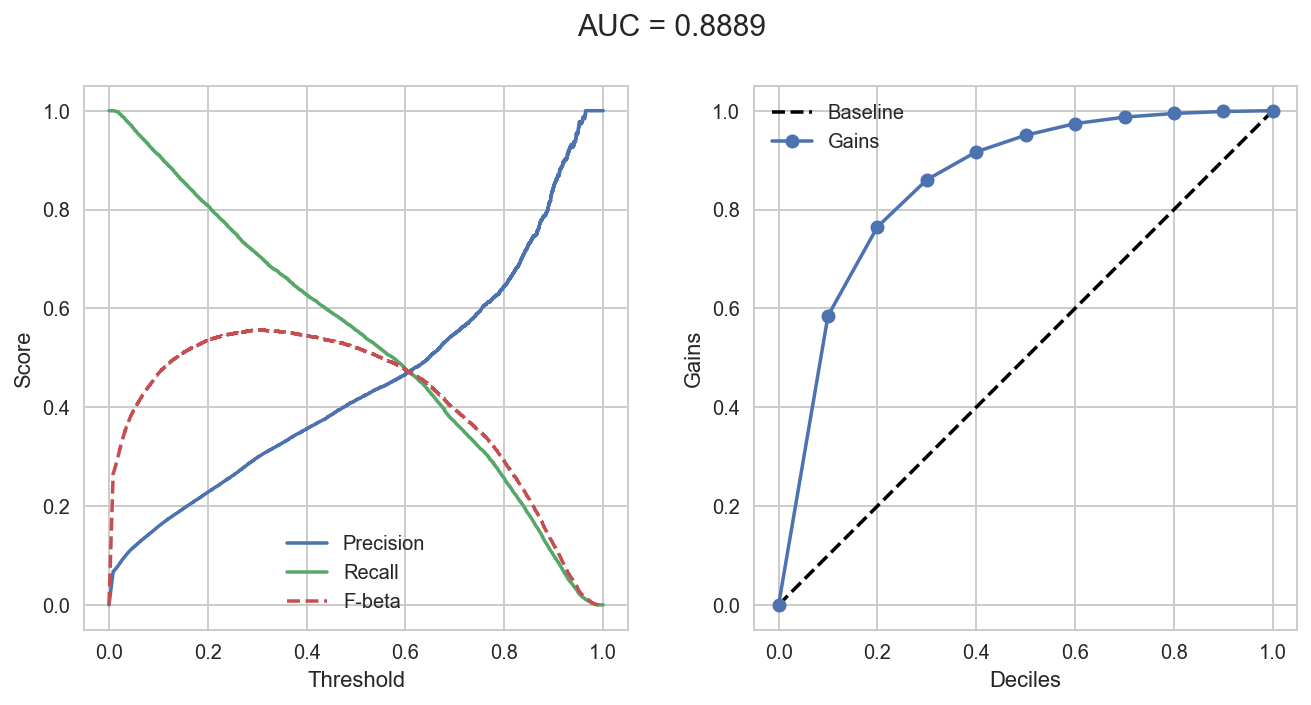

In [76]:
fl = FocalLoss(alpha=0.25, gamma=2)
d = lgb.Dataset(x, y, init_score=np.full_like(y, fl.init_score(y), dtype=float))

model = lgb.train(params=dict(verbose=-1), train_set=d, fobj=fl.lgb_obj)
yProb = special.expit(fl.init_score(y) + model.predict(x)*3)

auc = metrics.roc_auc_score(y, yProb)
fig, ax = plt.subplots(ncols=2, figsize=(11,5), sharex=True)
plotPRChart(y, yProb, ax=ax[0], beta=2)
plotCumulativeGains(y, yProb, ax=ax[1])
fig.suptitle(f'AUC = {auc:.4f}', fontsize=15)
plt.show()

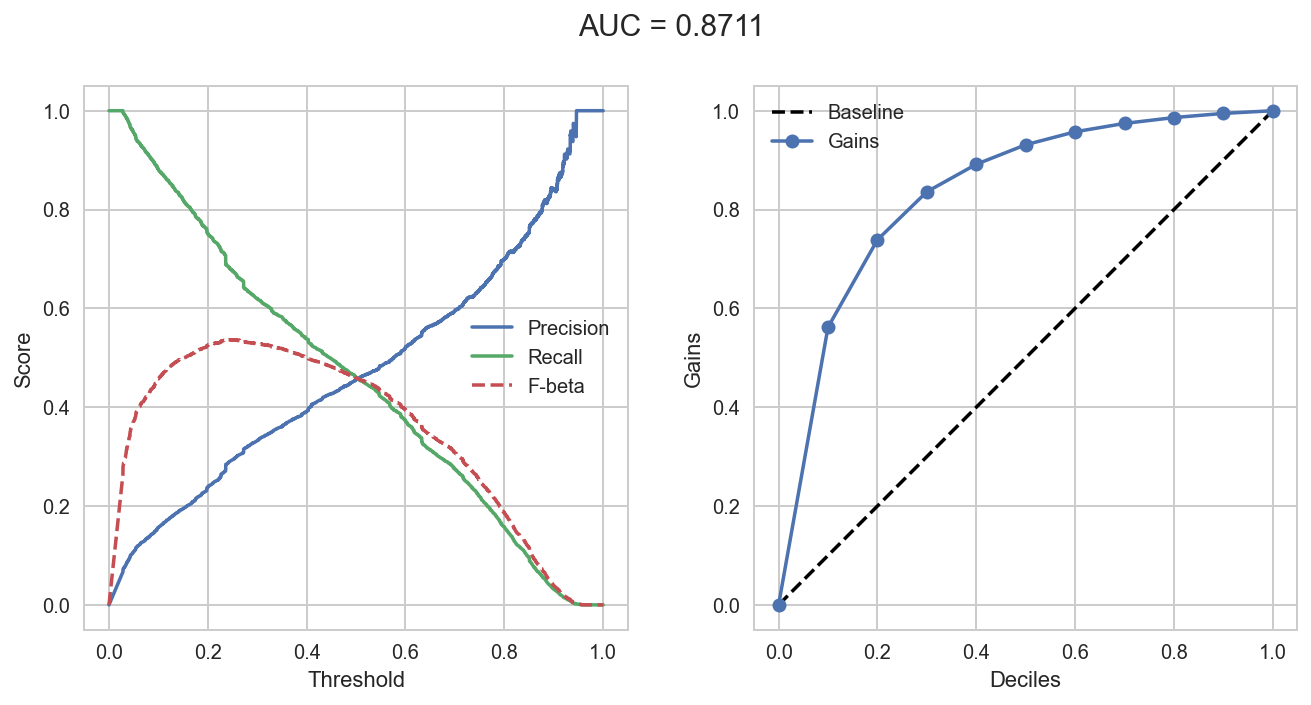

In [77]:
fl = FocalLoss(alpha=0.75, gamma=2)
d = xgb.DMatrix(x, y)

model = xgb.train(params={}, dtrain=d, obj=fl.lgb_obj)
yProb = special.expit(model.predict(d)*3)

auc = metrics.roc_auc_score(y, yProb)
fig, ax = plt.subplots(ncols=2, figsize=(11,5), sharex=True)
plotPRChart(y, yProb, ax=ax[0], beta=2)
plotCumulativeGains(y, yProb, ax=ax[1])
fig.suptitle(f'AUC = {auc:.4f}', fontsize=15)
plt.show()

### 1.3. Under-sampling
Let's say a binary labeled dataset has $N_0$ negative samples and $N_1$ positive samples (with $N_0\gg N_1$). [Under-sampling] is the process of reducing the majority class until there are $N_0^*$ negative samples left. This method is helpful for large datasets, but can accidentally drop informative data.

The rest of this section presents several down-sampling algorithm provided by Imbalanced-learn, which mainly differ in how they determine points to remove. They are divided into two groups: *controlled* techniques allowing us to specify how much data to remove, and *cleaning* techniques being [heuristics] for data cleaning.

[Under-sampling]: https://imbalanced-learn.org/stable/under_sampling.html#prototype-selection
[heuristics]: https://en.wikipedia.org/wiki/Heuristic

#### Controlled methods
All techniques in this group require us to provide `sampling_strategy`, which is usually set to a number indicating the desired class ratio, $N_1/N_0^*$. We can use either the basic [`RandomUnderSampler`], or the more advanced [`NearMiss`] which removes furthest negative samples from the positive class. With a pre-selected value of $K$, NearMiss has three variants presented as follows:
- NearMiss-1 keeps negative samples with the smallest average distance to $K$ nearest positive samples.
- NearMiss-2 keeps negative samples with the smallest average distance to $K$ furthest positive samples.
- NearMiss-3 first keeps several nearest negative samples to each positive sample and then keeps negative samples with the largest average distance to $K$ nearest positive samples. This version is considered less affected by outlier and is thus the most efficient, according to the authors.

[`RandomUnderSampler`]: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
[`NearMiss`]: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html

#### Cleaning methods
As introduced earlier, cleaning methods don't use the desired class ratio, thus the parameter `sampling_strategy` should be left alone. There are mainly three algorithms in this group:
- [`TomekLinks`] detects and removes any negative sample having the nearest neighbor falling into the minority class. Such a connection is called a Tomek link.
- [`CondensedNearestNeighbour`] uses 1-NN rule to interatively determine whether to keep a negative sample. Low execution time but is sensitive to noise.
- [`EditedNearestNeighbours`] trains a K-NN classifier and removes any sample which doesn't *agree enough* with its neighbors. There are two dropping strategies available (set via the `kind_sel` parameter): `mode` keeps an inspected point if at least $50\%$ neighbors are in the same class with it, and `all` keeps an inspected point if only all $100\%$ neighbors agree with it. The later is more aggressive and is the default.

[`TomekLinks`]: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html
[`EditedNearestNeighbours`]: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html
[`CondensedNearestNeighbour`]: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.CondensedNearestNeighbour.html

### 1.4. Over-sampling
Let's say a binary labeled dataset has $N_0$ negative samples and $N_1$ positive samples (with $N_0\gg N_1$). Over-sampling is the process of generating new observations for the minority class, so it will end up having $N_1^*$ samples. You can try a [`RandomOverSampler`] or another advanced method that intentionally creates *synthetic data*, which will be introduced in this section. All over-sampling algorithms require the parameter `sampling_strategy`, which is usually set to a number indicating the desired class ratio, $N_1^*/N_0$. There are some disadvantages of over-sampling you should be aware of:
- causing data leakage
- slowing down training
- adding incorrect information that hurts model performance

[`RandomOverSampler`]: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

#### Synthetic minority
SMOTE is published in the paper [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813) (2011). It uses a simple mechanism to create new data: the clone of a data point moves towards a neighbor that belongs to the same class. You can also think of this process as drawing a line between a point and one of its neighbor, then pick a new point somewhere on that line.

:::{image} ../image/smote.png
:height: 300px
:align: center
:::

Formally, denote $\mathbf{s}_n$ a data point of the minority class. Among its $K$ *same-class* nearest neighbors, randomly select a point $\mathbf{s}_k$ and a number $\lambda\in(0,1)$. A clone of $\mathbf{s}_n$ will be created using the formula:

$$\mathbf{s}_n+\lambda(\mathbf{s}_k-\mathbf{s}_n)$$

In SMOTE, the number of points to be synthesized are uniformally allocated to each sample in the minority class. In other words, each member of class $1$ will be cloned $N_1^*/N_1-1$ times. Also note that each clone is created with another value of $\lambda$.

[Synthetic Minority Oversampling Techique]: https://arxiv.org/pdf/1106.1813.pdf


#### SMOTE variants
Imbalanced-learn provides several SMOTE variants as well:
- [`BorderlineSMOTE`], which creates clones only from *borderline points* instead of from all positive samples. A borderline point is defined as a positive sample having more than a half of its neighbors belong to the negative class. This improvement bases on the design of many Machine Learning algorithms that attemp to learn the borderlines between classes, making borderline points easily misclassified. The impact of this algorithm can be thought as highlighting grey zones, so that prediction accuracy can be boosted a bit.
- [`SVMSMOTE`] is proposed based on the same idea as Borderline SMOTE, where support vectors of the positive class serve the same role as borderline points. If less than a half of $K$ neighbors of a point are of the majority class, then synthetic point will be created outside of the segment connnecting two points by setting $\lambda>1$.
- [`KMeansSMOTE`] firstly uses K-Means to divide the dataset into clusters, then use any cluster with at least $50\%$ positive samples will be used for cloning.
- [`ADASYN`] (Adaptive Synthetic) works similarly to regular SMOTE, but the clones of each positive sample will be proportional to the number of negative points in its $K$ nearest neighbors. The purpose of this is to generate more data in those regions with low density of the minority class.

[`SMOTE`]: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
[`BorderlineSMOTE`]: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html
[`SVMSMOTE`]: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html
[`KMeansSMOTE`]: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.KMeansSMOTE.html
[`ADASYN`]: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html

#### SMOTE combinations
As SMOTE can generate noisy samples, it makes sense to use cleaning under-sampling techniques to clean up the output out SMOTE. Imbalanced-learn implements this idea via [`SMOTETomek`] and [`SMOTEENN`].

[`SMOTETomek`]: https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html
[`SMOTEENN`]: https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html

### 1.5. Implementation: Imblearn
All over-samplers share a general hyperparameter, `sampling_strategy`, which supports a number of strategies. However, as we are focusing on binary classification, a float should be passed in, indicating the desired ratio between size of positive class and size of negative class: 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [26]:
df = pd.read_csv('../data/breast_cancer.csv')
x = df.drop(columns='target')
y = df['target']
xImb, yImb = make_imbalance(x, y, sampling_strategy={0: 212, 1: 50})
yImb.value_counts()

0    212
1     50
Name: target, dtype: int64

In [66]:
listResampler = [
    (1, SMOTE()),
    (2, ADASYN()),
    (3, NearMiss()),
    (4, SMOTETomek()),
]

mosaic = [
    [1, 2, 0, 0],
    [3, 4, 0, 0],
]

paramScatter = dict(cmap='Spectral', alpha=0.7)
paramTick = dict(bottom=False, left=False, labelbottom=False, labelleft=False)

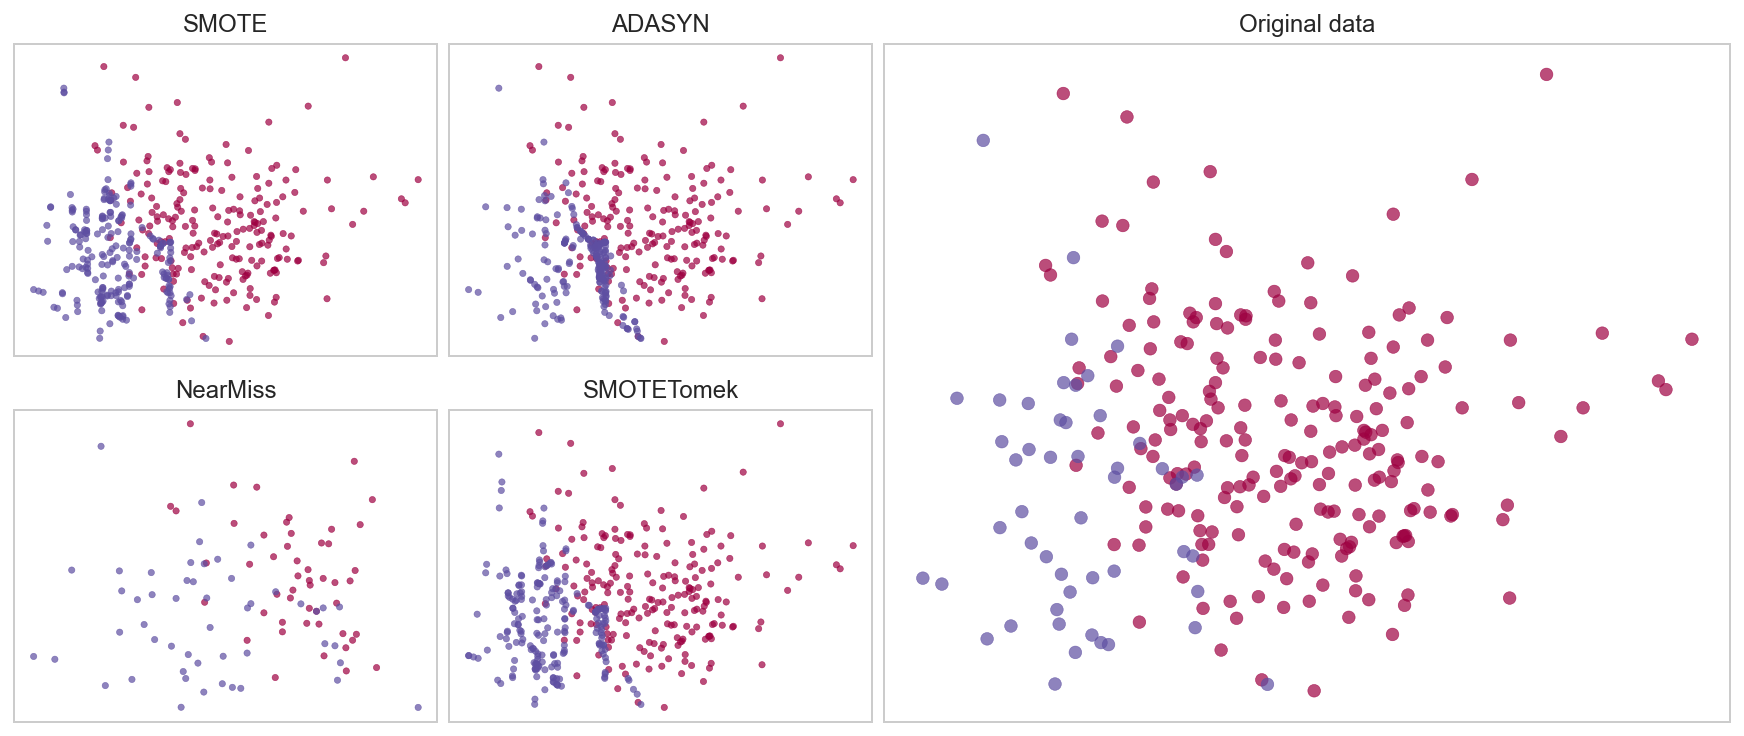

In [68]:
fig, ax = plt.subplot_mosaic(mosaic, figsize=(12,5), constrained_layout=True)

ax[0].scatter(xImb.mean_radius, xImb.mean_smoothness, c=yImb, s=40, **paramScatter)
ax[0].set_title('Original data')
ax[0].grid(False)
ax[0].tick_params(**paramTick)

for idx, resampler in listResampler:
    xRes, yRes = resampler.fit_resample(xImb, yImb)
    ax[idx].scatter(xRes.mean_radius, xRes.mean_smoothness, c=yRes, s=10, **paramScatter)
    ax[idx].set_title(resampler.__class__.__name__)
    ax[idx].grid(False)
    ax[idx].tick_params(**paramTick)

plt.show()

## 2. Uplift modeling

## 3. Learning to rank
[Learning to rank], or *ranking* in short, is a problem in [Information Retrieval] with many applications such as recommendation systems and search engines. The problem's goal is to *grade* a *document* given a *query*. This definition has covered a lot of terms, now let's place them into a movie recommender to have better understanding.
- A *query* $q$ represents a user who wants to see a list of interesting movies displayed at the home page. Can also be a user-movie pair, where the user wants to see relevent movies to the one he is watching.
- A *document* $d$ represents a movie to be introduced to the user.
- A *relevance score* $y$ is the grade we give to the movie with respect to the user. The scoring system is usually binary (relevant and non-relevant) or 5-level ordinal (excellent, good, normal, bad, terrible) and is integer-encoded with higher-is-better rule.

In order to learn the scoring pattern, we attemp to build a Machine Learning model $f(q,d)\rightarrow y$. This is just the general form, and we need to select the label (from $y$) for different approaches. For features, they can be genrally devided into three groups: (1) query features such as user demographic and logs data, (2) document features such as movie genre, and (3) dynamic features which consider both query and document such as number of times user $q$ has watched movie $d$ in the past.

[Learning to rank]: https://en.wikipedia.org/wiki/Learning_to_rank
[Information Retrieval]: https://en.wikipedia.org/wiki/Information_retrieval

:::{tip}

We can see that with relevance scores only, our data is just the pivot-longer form of the *utility matrix*. This form allows adding features of three groups described earlier, so we can incorporate more data into model training.

:::

### 3.1. Approaches
There are three approaches to solve the learning to rank problem as follows:
- *Pointwise*: We ignore the query column and reduce the task to a regression problem (for ordinal label) or classification problem (for binary label).
- *Pairwise*: We take the difference between every sample pair in the same query to construct training samples. We treat the task as a binary classification problem which decides if the two documents are equal or not. Like pointwise, pairwise approach also ignores the group structure.
- *Listwise*: This approach attemps to model the entire ranking list at once, which is more straightfoward. It is thus more complicated but can outperform pointwise and pairwise.

### 3.2. Evaluation
As we see, the label of the ranking problem is similar to recommendation problem, so they use the same evaluation metric. More specifically, metrics considering only top $K$ items is commonly used in practice: MAP@K for binary label and NDCG for ordinal label.

### 3.3. Implementation
In this section we will train several Gradient Boosting rankers on the [MS rank dataset]. All algorithms require features, labels and queries for training; but there are some minor differences between their implementations:
- During initialization: objective functions and evaluation metrics.
- During training: queries are provided via IDs or document counts. Features and labels are also required as usual.

|Class|Objective|Metric|Query ids|Document counts|
|:-|:-|:-|:-|:-|
|[`XGBRanker`]|`objective`|`eval_metric`|`qid`|`group`|
|[`LGBMRanker`]|`objective`|`metric`||`group`|
|[`CatBoostRanker`]|`objective`|`eval_metric`|`group_id`||

[MS rank dataset]: https://www.microsoft.com/en-us/research/project/mslr/
[`XGBRanker`]: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRanker
[`LGBMRanker`]: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRanker.html
[`CatBoostRanker`]: https://catboost.ai/en/docs/concepts/python-reference_catboostranker

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cgb

In [2]:
dfTrain = pd.read_csv('../data/msrank_train.csv')
dfTest = pd.read_csv('../data/msrank_test.csv')

In [3]:
x_train = dfTrain.iloc[:, 2:]
y_train = dfTrain.relevance_score
qTrain = dfTrain.query_id

x_test = dfTest.iloc[:, 2:]
y_test = dfTest.relevance_score
qTest = dfTest.query_id

In [4]:
model = cgb.CatBoostRanker()
model.fit(x_train, y_train, group_id=qTrain, verbose=0)
yPred = model.predict(x_test)

In [31]:
model = lgb.LGBMRanker()
model.fit(x_train, y_train, group=qTrain.value_counts())
yPred = model.predict(x_test)

In [ ]:
model = xgb.XGBRanker()
model.fit(x_train, y_train, group=qTrain.value_counts())
yPred = model.predict(x_test)

## Resources
- *medium - [Oversampling and undersampling: ADASYN vs ENN](https://medium.com/quantyca/oversampling-and-undersampling-adasyn-vs-enn-60828a58db39)*
- *sci2s.ugr - [Borderline SMOTE](https://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf )*
- *diva-portal - [ADASYN](https://www.diva-portal.org/smash/get/diva2:1519153/FULLTEXT01.pdf)*
- *maxhalford.github - [Focal loss implementation for LightGBM](https://maxhalford.github.io/blog/lightgbm-focal-loss/)*
- *leimao.github - [Focal Loss explained](https://leimao.github.io/blog/Focal-Loss-Explained/)*
- *neptune - [Binary classification tips and tricks from Kaggle](https://neptune.ai/blog/binary-classification-tips-and-tricks-from-kaggle)*
- *jstage.jst.go - [A short introduction to Learning to Rank](https://www.jstage.jst.go.jp/article/transinf/E94.D/10/E94.D_10_1854/_pdf/-char/en)*
- *everdark.github - [Introduction to Learning to Rank](https://everdark.github.io/k9/notebooks/ml/learning_to_rank/learning_to_rank.html)*


In [ ]:
pip install -U imbalanced-learn